In [ ]:
import pybamm
import matplotlib.pyplot as plt
import numpy as np


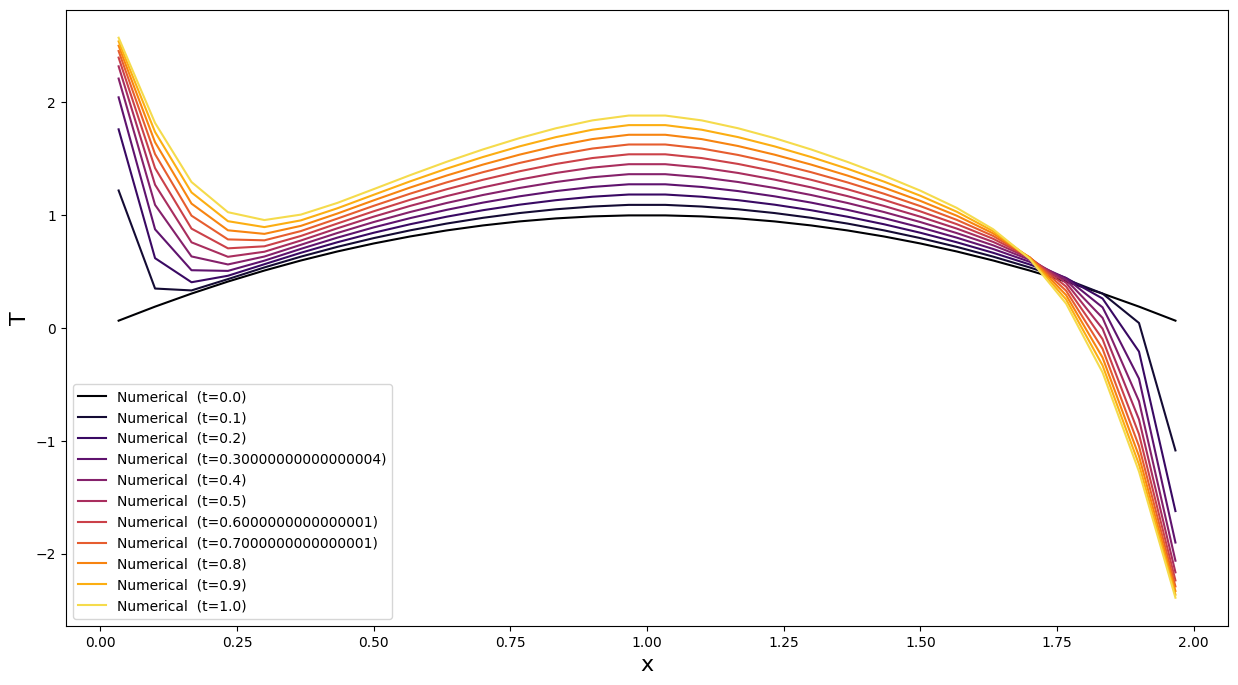

In [34]:
model = pybamm.BaseModel()
x = pybamm.SpatialVariable("x", domain="rod", coord_sys="cartesian")
T = pybamm.Variable("Temperature", domain="rod")
k = pybamm.Parameter("Thermal diffusivity")
N = -k * pybamm.grad(T)  # Heat flux


peakScale = 1 # scales the Peak
peakWidth = 1 # smaller multiplier = broader base but shorter || larger multiplier = tighter base but taller
Q = peakScale*(1 - peakWidth*pybamm.Function(np.abs, x - 1))  # Source term


dTdt = -pybamm.div(N) + Q  # The right hand side of the PDE
model.rhs = {T: dTdt}  # Add to model
model.boundary_conditions = {
    T: {
        "left": (pybamm.Scalar(3), "Dirichlet"),
        "right": (pybamm.Scalar(-3), "Dirichlet"),
    }
}
model.initial_conditions = {T: 2 * x - x**2}
model.variables = {"Temperature": T, "Heat flux": N, "Heat source": Q}
geometry = {"rod": {x: {"min": pybamm.Scalar(0), "max": pybamm.Scalar(2)}}}
param = pybamm.ParameterValues({"Thermal diffusivity": 0.0125})
param.process_model(model)
param.process_geometry(geometry)
submesh_types = {"rod": pybamm.Uniform1DSubMesh}
var_pts = {x: 30}
mesh = pybamm.Mesh(geometry, submesh_types, var_pts)
spatial_methods = {"rod": pybamm.FiniteVolume()}
disc = pybamm.Discretisation(mesh, spatial_methods)
disc.process_model(model)
solver = pybamm.ScipySolver()
t = np.linspace(0, 1, 100)
solution = solver.solve(model, t)
T_out = solution["Temperature"]


N = 100  # number of Fourier modes to sum
k_val = param[
    "Thermal diffusivity"
]  # extract value of diffusivity from the parameters dictionary


# Fourier coefficients
def q(n):
    return (8 / (n**2 * np.pi**2)) * np.sin(n * np.pi / 2)


def c(n):
    return (16 / (n**3 * np.pi**3)) * (1 - np.cos(n * np.pi))


def b(n):
    return c(n) - 4 * q(n) / (k_val * n**2 * np.pi**2)


def T_n(t, n):
    return (4 * q(n) / (k_val * n**2 * np.pi**2)) + b(n) * np.exp(
        -k_val * (n * np.pi / 2) ** 2 * t
    )


# Sum series to get the temperature
def T_exact(x, t):
    out = 0
    for n in np.arange(1, N):
        out += T_n(t, n) * np.sin(n * np.pi * x / 2)
    return out

x_nodes = mesh["rod"].nodes  # numerical gridpoints
xx = np.linspace(0, 2, 11)  # fine mesh to plot exact solution
plot_times = np.linspace(0, 1, 11)  # times at which to plot

plt.figure(figsize=(15, 8))
cmap = plt.get_cmap("inferno")
for i, t in enumerate(plot_times):
    color = cmap(float(i) / len(plot_times))
    plt.plot(
        x_nodes,
        T_out(t, x=x_nodes),
        "-",
        color=color,
        label=f"Numerical  (t={plot_times[i]})",
    )
    '''
    plt.plot(
        xx,
        T_exact(xx, t),
        "o",
        color=color,
        label=f"Exact (t={plot_times[i]})",
    )
    '''
plt.xlabel("x", fontsize=16)
plt.ylabel("T", fontsize=16)
plt.legend()
plt.show()

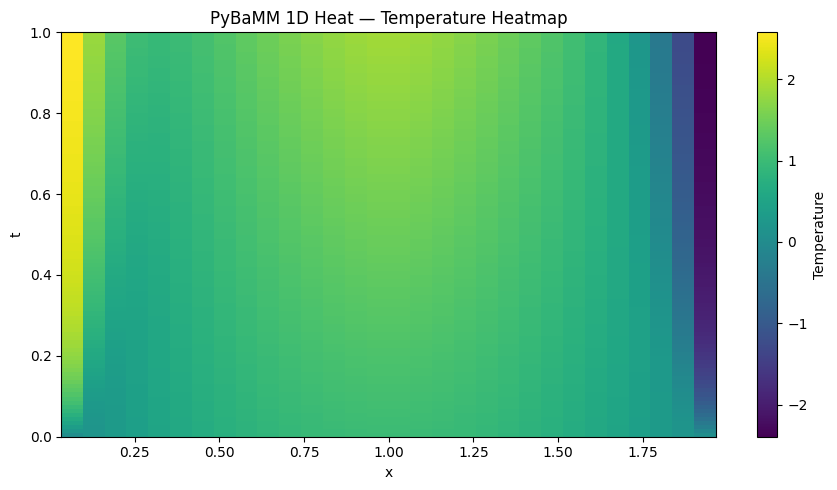

In [35]:
# Ensure we have vector axes
t_eval = np.atleast_1d(solution.t)                 # (nt,)
x_eval = np.atleast_1d(np.array(mesh["rod"].nodes))# (nx,)

# Fallback if t_eval somehow collapsed to scalar
if t_eval.size == 1:
    t_eval = np.linspace(float(solution.t[0]), float(solution.t[-1]) if solution.t.size>0 else 1.0, 100)

def sampleProcessedVar(pvar, t_vals, x_vals):
    t_vals = np.atleast_1d(t_vals)
    x_vals = np.atleast_1d(x_vals)
    M = np.empty((t_vals.size, x_vals.size), dtype=float)
    for i, ti in enumerate(t_vals.tolist()):
        # evaluate scalar for each (t,x)
        row = [float(np.asarray(pvar(t=ti, x=float(xi)))) for xi in x_vals.tolist()]
        M[i, :] = row
    return M

Tmat = sampleProcessedVar(T_out, t_eval, x_eval)

# Guard against NaNs/flat range
if not np.isfinite(Tmat).any():
    raise RuntimeError("All samples are NaN/Inf. Check variable name/domain and x range.")
if np.nanmax(Tmat) == np.nanmin(Tmat):
    Tmat = Tmat + 1e-12

# Plot heatmap: color = Temperature
plt.figure(figsize=(9,5))
plt.imshow(
    Tmat, origin="lower",
    extent=[float(x_eval.min()), float(x_eval.max()), float(t_eval.min()), float(t_eval.max())],
    aspect="auto"
)
plt.xlabel("x"); plt.ylabel("t")
cbar = plt.colorbar(); cbar.set_label("Temperature")
plt.title("PyBaMM 1D Heat — Temperature Heatmap")
plt.tight_layout(); plt.show()


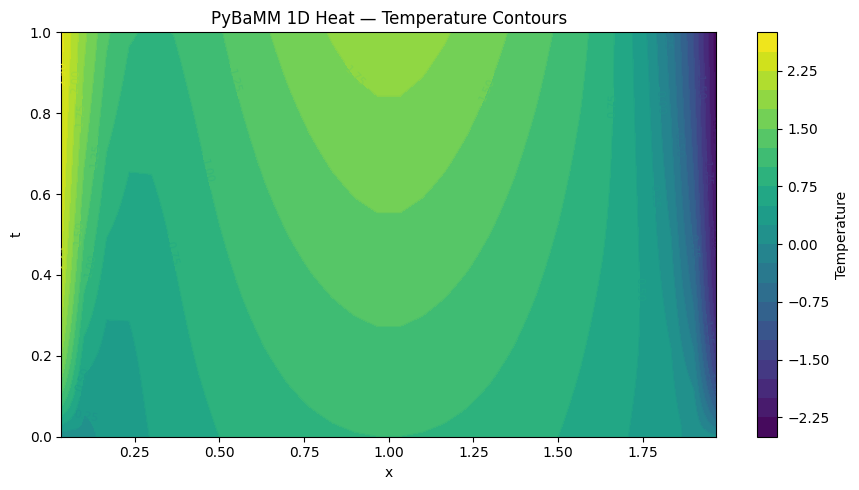

In [36]:
tGrid, xGrid = np.meshgrid(t_eval, x_eval, indexing="ij")
levels = 20

plt.figure(figsize=(9,5))
cf = plt.contourf(xGrid, tGrid, Tmat, levels=levels)
cl = plt.contour(xGrid, tGrid, Tmat, levels=levels, linewidths=0.6)
plt.clabel(cl, fmt="%.2f", fontsize=8)
cbar = plt.colorbar(cf); cbar.set_label("Temperature")
plt.xlabel("x"); plt.ylabel("t")
plt.title("PyBaMM 1D Heat — Temperature Contours")
plt.tight_layout(); plt.show()
